Comparing transect flows and BC flows
--

Had been some issues, maybe with `cfg08` output, where the flow appeared to
be distributed over the wrong range of layers.

So far, when looking at the `cfg010` output, it seems correct.  Flow summed
over the python slice `[kb-1:kt-1+1]` matches the imposed river flow on the
upstream end. The interpretation is that `kb` as written to the netcdf file
is 1-based, so subtract 1 to get 0-based.  `kt` is also 1-based, so subtract 
1, and then add 1 back in to convert from the inclusive indexing in the file
to exclusive indexing in the python world. 

In [19]:
import os.path
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
import stompy.grid.unstructured_grid as unstructured_grid
from stompy import utils
import xarray as xr
import pandas as pd
import pdb
from stompy.spatial import wkb2shp

In [2]:
%matplotlib notebook

In [3]:
shp = '../../gis/esg-flow-lines/flow_lines.shp'
transects=wkb2shp.shp2geom(shp)

In [5]:
run_dir='runs/cfg011_farm12_20180310'

ncfile = os.path.join(run_dir,'ptm_average.nc_0000.nc')
ds=xr.open_dataset(ncfile)
grd = unstructured_grid.UnstructuredGrid.read_ugrid(ds)

bc_file = os.path.join(run_dir,'Estuary_BC.nc')
bc = xr.open_dataset(bc_file)

In [26]:
bc_flow = {}
# use names in shapefile
bc_flow['San_Joaquin_upstream_boundary'] = bc['boundary_Q'][:,0]
bc_flow['San_Joaquin_downstream_boundary'] = -bc['boundary_Q'][:,1]
#SJ_in = bc['boundary_Q'][:,0]
dnum_bc = bc['time']

dtime = ds['Mesh2_data_time'].values

flow_ts = {}
bc_names = ['San_Joaquin_upstream_boundary','San_Joaquin_downstream_boundary']
for ntran, row in enumerate(transects):
    name=row['name']
    pts=np.array(row['geom'])
    # get edges 
    n1 = grd.select_nodes_nearest(pts[0]) # start node of transect
    n2 = grd.select_nodes_nearest(pts[1]) # end node of transect
    nodes_tran = grd.shortest_path(n1, n2, return_type='nodes')
    edges_tran = grd.shortest_path(n1, n2, return_type='edges')
    ecenters = grd.edges_center()[edges_tran]
    normals = grd.edges_normals(edges_tran)
    nedges = len(edges_tran)
    signs = np.zeros(nedges, np.float64)
    signed_normals = np.zeros_like(normals)
    for ne, edge in enumerate(edges_tran):
        enodes = grd.edges['nodes'][edge] 
        loc0 = np.where(nodes_tran == enodes[0])[0][0]
        loc1 = np.where(nodes_tran == enodes[1])[0][0]
        if loc1 == loc0 + 1:
            signs[ne] = -1.0
        elif loc1 == loc0 - 1:
            signs[ne] = 1.0
        else:
            raise Exception("Surprising result in node ordering")
        signed_normals[ne,:] = np.asarray([normals[ne,0]*signs[ne],
                                           normals[ne,1]*signs[ne]])

    #nsteps = len(dtime)
    tflow = pd.DataFrame() #np.zeros(nsteps, np.float64)
    tflow['dtime']=dtime
    tflow=tflow.set_index('dtime')
    
    tflow['[kb-1,kt-1+1]']=0.0
    tflow['[0,Nk]']=0.0
    
    dt_seconds = 30.*60.
    h_flow_var=ds['h_flow_avg']
    kbj = ds['Mesh2_edge_bottom_layer'].values[edges_tran,...]
    ktj = ds['Mesh2_edge_top_layer'].values[edges_tran,...]

    for nt,t in utils.progress(enumerate(dtime)):
        h_flow_avg_edges = h_flow_var.isel(nMesh2_data_time=nt).values[edges_tran,...]
        
        # vertical sum -- all layers
        # h_flow_avg_wcs = np.nansum(h_flow_avg_edges,axis=1)
            
        # horizontal sum
        for ne, edge in enumerate(edges_tran):
            kb=kbj[ne,nt]-1
            kt=ktj[ne,nt]-1+1 # convert 1-based to 0-based, but also inclusive to exclusive
            #tflow[nt] += h_flow_avg_wcs[ne]*signs[ne]
            # tflow[nt] += np.nansum(h_flow_avg_edges[ne,kb:kt]) * signs[ne]
            tflow.loc[t,'[kb-1,kt-1+1]']+= np.nansum(h_flow_avg_edges[ne,kb:kt]) * signs[ne]
            tflow.loc[t,'[0,Nk]'] += np.nansum(h_flow_avg_edges[ne,:]) * signs[ne]

    flow_ts[name] = tflow
    # break

INFO:utils:88
INFO:utils:177
INFO:utils:265
INFO:utils:351
INFO:utils:437
INFO:utils:87
INFO:utils:175
INFO:utils:263
INFO:utils:351
INFO:utils:440
INFO:utils:94
INFO:utils:186
INFO:utils:281
INFO:utils:374
INFO:utils:469
INFO:utils:108
INFO:utils:217
INFO:utils:325
INFO:utils:435
INFO:utils:101
INFO:utils:201
INFO:utils:301
INFO:utils:401
INFO:utils:500
INFO:utils:111
INFO:utils:222
INFO:utils:333
INFO:utils:443


<IPython.core.display.Javascript object>


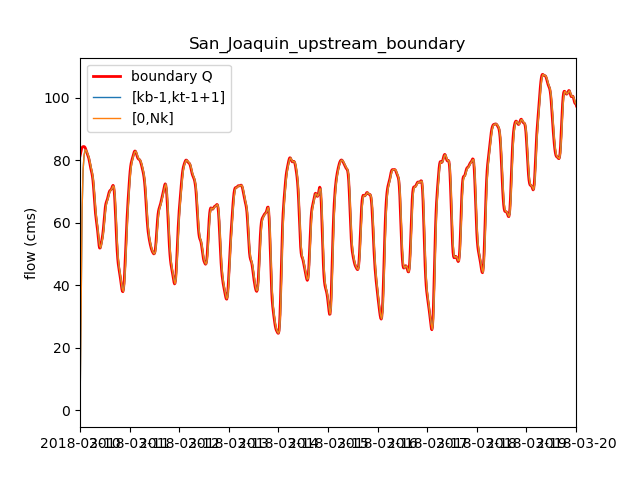

<IPython.core.display.Javascript object>


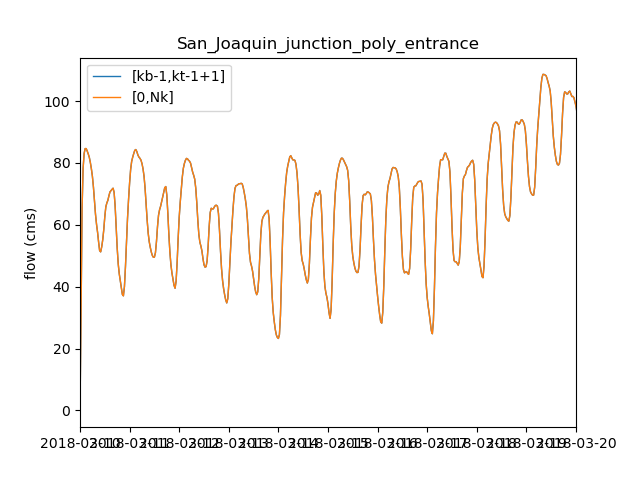

<IPython.core.display.Javascript object>


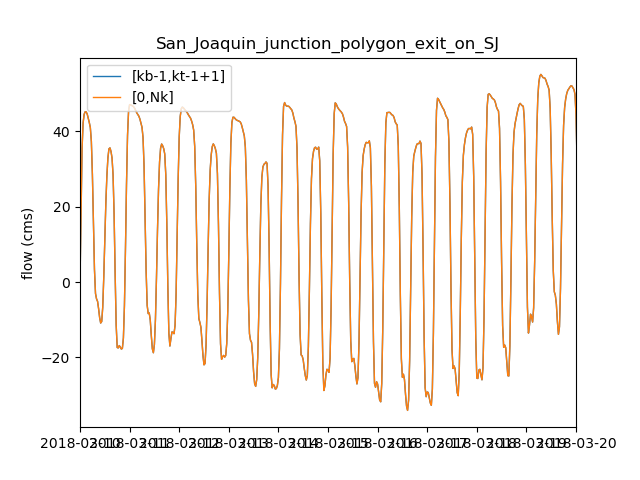

<IPython.core.display.Javascript object>


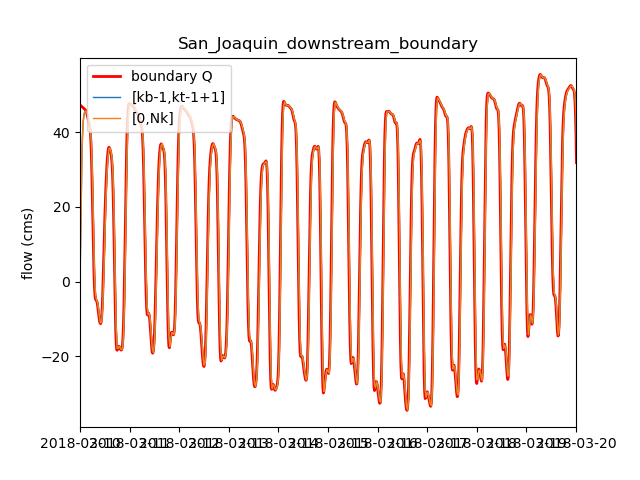

<IPython.core.display.Javascript object>


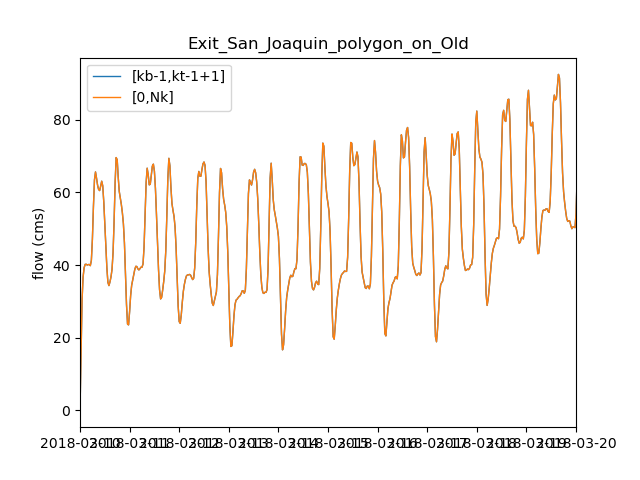

<IPython.core.display.Javascript object>


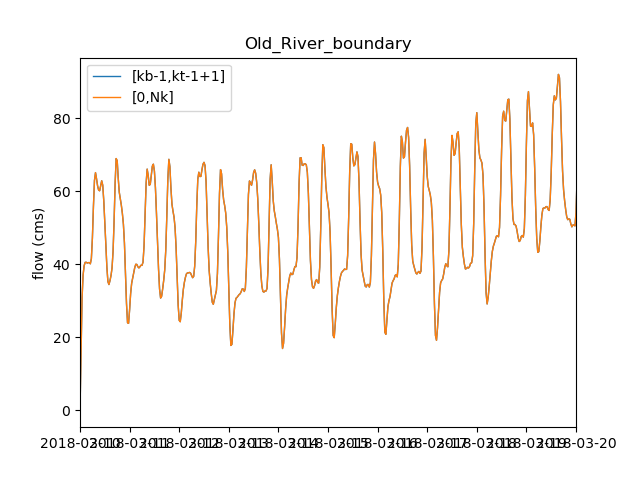

In [29]:

for name in flow_ts:
    fig,ax=plt.subplots()
    t_offset = 15.*60

    tflow=flow_ts[name]

    if name in bc_names:
        ax.plot(dnum_bc,bc_flow[name],'r-',lw=2.0,label='boundary Q')

    for col in tflow.columns:
        ax.plot(tflow.index.values,tflow[col],lw=1.0,label=col)

    
    dstart = datetime(2018,3,10)
    dend = datetime(2018,3,20)
    ax.set_xlim([dstart,dend])
    ax.set_ylabel('flow (cms)')
    ax.legend(loc='upper left')
    #dayslocator = matplotlib.dates.DayLocator(bymonthday = [1,5,10,15,20,25,30])
    #plt.gca().xaxis.set_major_locator(dayslocator)
    #plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m-%d"))
    ax.set_title(name)
    

<IPython.core.display.Javascript object>


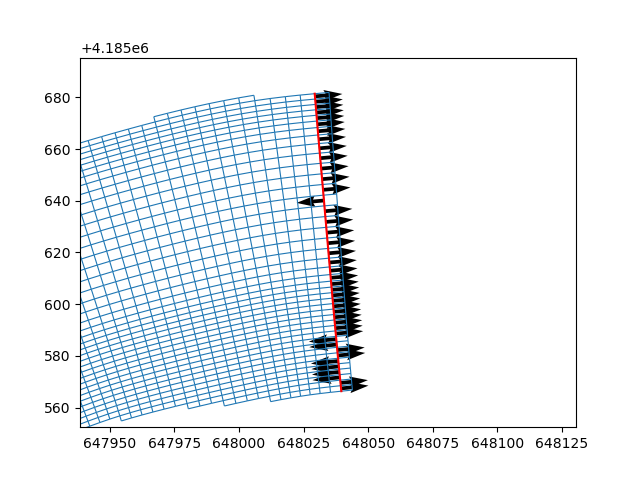

(648014.387715, 648054.491305, 4185552.3838, 4185695.36765)

In [18]:
fig,ax=plt.subplots()
grd.plot_edges()
nxy=grd.nodes['x'][nodes_tran]
ax.plot( nxy[:,0], nxy[:,1], 'r-')

ecenters = grd.edges_center()[edges_tran]
normals = grd.edges_normals(edges_tran)

ax.quiver( ecenters[:,0],ecenters[:,1], normals[:,0],normals[:,1])

ax.set_adjustable('datalim')
pad=15.0
ax.axis(xmin=ecenters[:,0].min()-pad,
        xmax=ecenters[:,0].max()+pad,
        ymin=ecenters[:,1].min()-pad,
        ymax=ecenters[:,1].max()+pad )
